In [1]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from Stats import Entity, Resource, Source

## Description of problem: 

We are going to model a restaurant.

Customers start by ordering, which is passed to the kitchen.
The Kitchen is described as follows: 
 - 2 cooks
 - 3 things to order:
   - fish -- 15 mins to prepare
   - burger -- 5 mins to prepare
   - salad -- 8 mins to prepare
   
Then must wait for a seat
- people will sit for between 20-30 minutes. 
- Capacity: 4
- Assume all attendees are dining alone (no need to worry about specific party capacity, or matching to tables).


## Step 1: Setting up Resource Classes

First things first, let's define classes to represent our Kitchen and DiningRoom Resources. 
These resources will subclass the `Resource` class from the Stats library provided for this course in `stats.py`. 

The `Resource` class from the Stats library provides some handy helper methods for tracking statistics about Resource usage during simulation, so you don't have to manually instrument this yourself (as long as you subclass Resource).


We must define the following for each resource:
- a name attribute. This should be unique across all resource classes that you define
- a `next_service_time` function that computes the service time for an entity

Other configuration for resource that is done when you construct an instance:
- capacity -- this is how many entities the resource can process in parallel (e.g. a capacity of 2 on kitchen means 2 chefs).

In [2]:
# Our Kitchen class subclasses resource. We give it a unique name of "kitchen"
class Kitchen(Resource):
    def __init__(self, env, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
    
    def next_service_time(self, entity):
        """
        Defines preparation time for each dish
        Since we can pass the entity being processed to next_service_time when we call it, 
        we can react to the requirements of the entity (e.g. fish takes longer to prepare)
        """
        if entity.attributes["food"] == "Fish":
            return 100
        elif entity.attributes["food"] == "Burger":
            return 5
        elif entity.attributes["food"] == "Salad":
            return 8
        else:
            raise Exception("Restaurant does not serve this kind of food")
        

# Our DiningRoom class subclasses Resource. We give it a unique name of "DiningRoom"
class DiningRoom(Resource):
    def __init__(self, env, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
    
    def next_service_time(self, entity):
        """
        random integer of time between 20 and 30 minutes per problem specification
        """
        return np.random.randint(20, 30) # 20 to 30 minute seating per entity



## Step 2: Setting up Entity Class

An entity is conceptually the "things passing through your simulation". In the case of a restaurant, we can think of customers as the entities.  

These entities will travel through the simulation, will request resources, will perform actions that take time, might reneg and jump out of long queues, etc... All of this behavior should be defined in your entity class.

Entities should subclass the `Entity` class from the stats library. The `Entity` class in the Stats library provides a bunch of methods useful for collecting summary statistics about an entity's trip through the system.

An entity class should define the following:
- a `process(self, resource1, resource2, ...)` function) -- this defines how entities interact with resources in the system. It should accept all relevant resources as parameters.

Entities have the following methods available, which should be used in the body of your `process` function:
- self.request_resource(resource) -- this function has the entity submit a resource request to the resource provided (e.g. self.request_resource(kitchen) will return a request to the kitchen).
- self.start_service_at_resource(resource) -- this function logs when the resource is ready to begin processing the request of the entity. This is needed for statistics gathering.
- self.release_resource(resource, request) -- this function will release the requested resource, freeing it up for another entity to use.

See the definition of the `process` function in the Customer resource below for an example of how to interact with multiple resources during processing.

In [3]:
# entities are in charge of the order in which interactions with resources occur
class Customer(Entity):
    def __init__(self, env, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
    
    # template method for all of the resources it needs to interact with
    def process(self, kitchen, dining_room):
        
        # interface with kitchen
        request = self.request_resource(kitchen)
        yield request
        
        self.start_service_at_resource(kitchen)
        cook_time = kitchen.next_service_time(self) # next_service_time is defined in kitchen
        yield self.env.timeout(cook_time)
        
        self.release_resource(kitchen, request)
        
        # interface with dining_room
        request = self.request_resource(dining_room)
        yield request
        
        self.start_service_at_resource(dining_room)
        seat_time = dining_room.next_service_time(self) # next_service_time is defined in dining_room
        yield self.env.timeout(seat_time)
        
        self.release_resource(dining_room, request)

## Step 3: Setting up Source Class

Now that we have our resource and Entity classes defined, we should implement our Source class. 

Think of the source as the place where the simulation starts. It defines how often entities will arrive to the system (interarrival time) and how those entities are defined. It also keeps track of the number of entities created, and provides helper methods for calculating summary statistics at the end of simulation.

Your source should subclass the `Source` class provided in the stats package.

A source must have:
- an `interarrival_time_generator` -- this is a generator function that will yield the next time that an entity is to be constructed and processed by the simulation. 
- a `build_entity` function -- this defines how entities are constructed when the source needs to build a new one. You can define how entity attributes are selected in this function (more on attributes later)

Additional source configuration:
- number -- this is the number of entities that will be produced during simulation.

In [4]:
# The source is what contains the interarrival time definition, and rules for constructing entities 
# with various attribute sets.
class CustomerSource(Source):
    def __init__(self, env, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
        self.count = 0 # this is used for uniquely naming entities
    
    def interarrival_time_generator(self):
        while True:
            yield np.random.choice([1,10,15,20], p=[0.5, 0.2, 0.2, 0.1])
    
    def sample_from_foods(self):
        return np.random.choice(["Fish", "Burger", "Salad"], p=[0.1,0.7,0.2])
    
    def build_entity(self):
        self.count += 1
        food = self.sample_from_foods()
        # pass attributes as kwargs
        # pass env and the name of the entity
        entity = Customer(env, name=f"Customer {self.count}", food=food)
        return entity

## Step 4: Define main "process"

Consider this the main method of the simulation. It doesn't necessarily have to be a function of its own... but we need this small bit of code to orchestrate the simulation.

The dispose function is needed for statistics gathering. It tells us when an entity has finished processing. We use callbacks.append() to make sure that dispose is the last thing that happens to the entity after it has traversed through the system. 

I might be able to hide this dispose implementation detail a bit more.

In [5]:
def process(env, customer_source, kitchen, dining_room):
    """ Generate arrivals into our simulation
    
    Arguments:   
     env:  Our simulation environment
     source: the source of entities for our simulation
     resource: Shared resource
    """
    
    def dispose(entity):
        return lambda _: entity.dispose()
    
    for arrival_time, customer in customer_source.next_entity():
        yield arrival_time # wait for the next entity to appear
        processed_entity = env.process(customer.process(kitchen, dining_room))
        processed_entity.callbacks.append(dispose(customer))


## Step 5: Configure Classes 

Before beginning simulation, you need to create instances of your source and resource classes. You can pass any parameterizeable configuration to classes at this time (e.g. the capacity of each resource or the number of entities to create from the source).

Also need to construct a simpy.Environment(), and pass this to each class in its constructor.

In [6]:
# Create simulation environment
env = simpy.Environment()

# Configure source to generate fixed number of entities
source = CustomerSource(env, number=10)

# Configure DiningRoom to have space for 4 diners
dining_room = DiningRoom(env, capacity=2)

# Configure Kitchen to have 2 chefs
kitchen = Kitchen(env, capacity=2)

# Aside: if students want to tune various parameters of the simulation, they could configure each component
#        of the simulation here, then loop over the construction of each with different combinations of parameters

## Step 6: Run Simulation 

Running the simulation is pretty simple... just pass your process function with all configured objects to the env.process function. 
Then call env.run()

In [7]:
env.process(process(env, source, kitchen, dining_room))
env.run()

Customer Customer 1 requesting Kitchen: 1
Customer Customer 1 started processing at Kitchen : 1
Customer Customer 2 requesting Kitchen: 2
Customer Customer 2 started processing at Kitchen : 2
Customer Customer 3 requesting Kitchen: 3
Customer Customer 4 requesting Kitchen: 4
Customer Customer 5 requesting Kitchen: 5
Customer Customer 1 finished at Kitchen: 6
Customer Customer 1 requesting DiningRoom: 6
Customer Customer 1 started processing at DiningRoom : 6
Customer Customer 3 started processing at Kitchen : 6
Customer Customer 2 finished at Kitchen: 7
Customer Customer 2 requesting DiningRoom: 7
Customer Customer 2 started processing at DiningRoom : 7
Customer Customer 4 started processing at Kitchen : 7
Customer Customer 3 finished at Kitchen: 11
Customer Customer 3 requesting DiningRoom: 11
Customer Customer 5 started processing at Kitchen : 11
Customer Customer 4 finished at Kitchen: 12
Customer Customer 4 requesting DiningRoom: 12
Customer Customer 5 finished at Kitchen: 16
Custo

## Step 7: Extract Summary Statistics from Source / Resource

Source provides methods that calculate summary statistics about the entities while they were in the system. 

Resource provides methods to see what the queue was like at each resource over time.

See the following code blocks for some plots and calculations made with the summary stats.

In [8]:
system_time = source.get_total_times()
print("total_time:", source.get_total_times())
print("waiting_time:", source.get_waiting_times())
print("processing_time:", source.get_processing_times())

print(int(env.now))

queue_over_time_kitchen = kitchen.queue_size_over_time() # sample queue length
print(queue_over_time_kitchen)


queue_over_time_dining_room = dining_room.queue_size_over_time() # sample queue length
print(queue_over_time_dining_room)

total_time: [31, 30, 53, 54, 73, 59, 72, 79, 97, 99]
waiting_time: [0, 0, 24, 23, 46, 28, 47, 52, 62, 72]
processing_time: [31, 30, 29, 31, 27, 31, 25, 27, 35, 27]
128
[0, 0, 0, 1, 2, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


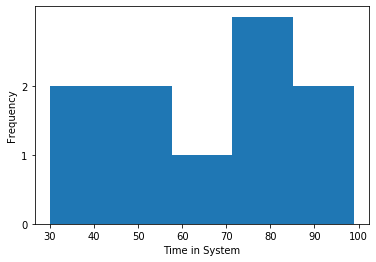

In [9]:
plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 0.1875
Max in queue: 3


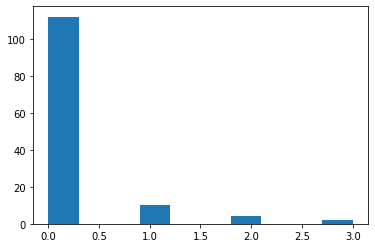

In [10]:
"""
Histogram of queue over time
"""
plt.hist(queue_over_time_kitchen)
print(f"Average number in queue: {np.mean(queue_over_time_kitchen)}")
print(f"Max in queue: {np.max(queue_over_time_kitchen)}")

Average number in queue: 2.578125
Max in queue: 6


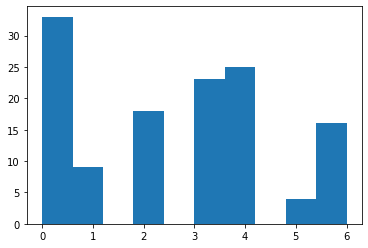

In [11]:
plt.hist(queue_over_time_dining_room)
print(f"Average number in queue: {np.mean(queue_over_time_dining_room)}")
print(f"Max in queue: {np.max(queue_over_time_dining_room)}")

In [12]:
print(f"max system time {np.max(system_time)}")
# 50th percentile, or median
print(f"50th percentile time {np.percentile(system_time,50)}")
print(f"std system time {np.std(system_time)}")

max system time 99
50th percentile time 65.5
std system time 22.737853900489377


## What next? 

Adjust capacities at each resource and see how the summary statistics change.
- how many chefs do you need in the kitchen to ensure 0 wait times with the current interarrival function? 
- What if we expanded our dining room... How big would we need to make the average wait time for a seat to be under 10 minutes? 

Could also adjust interarrival times / resource service times to see how that impacts
- What if we retrained chefs to cook fish 5 seconds faster... would that impact wait times? 
- What if we get a huge rush at night and interarrival time spikes to 1 minute. How bad would wait times get? 
- How to implement reneging customers? 